In [13]:
import osmnx
import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import contextily as cx
import copy

from matplotlib_scalebar.scalebar import ScaleBar
from geemap import cartoee
from shapely.geometry import shape
from pyrosm import OSM
from pyrosm import get_data

In [14]:
osmnx.config(timeout=10000) # set max osmnx timeout
local_crs = 2154  # France's crs

### Download data
Our study area for this example notebook will be the centre of Paris. below, a map with the study area can be found.
For this area, we will download some data from OpenStreetMap, specifically:

- Streets
- Buildings

In [15]:
# study area boundaries
sa = osmnx.geocode_to_gdf('Caen, France')
sa.to_parquet('./data/sa.parquet')

C:\Users\b9066009\AppData\Local\Temp\ipykernel_15668\1295965082.py:3: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  sa.to_parquet('./data/sa.parquet')


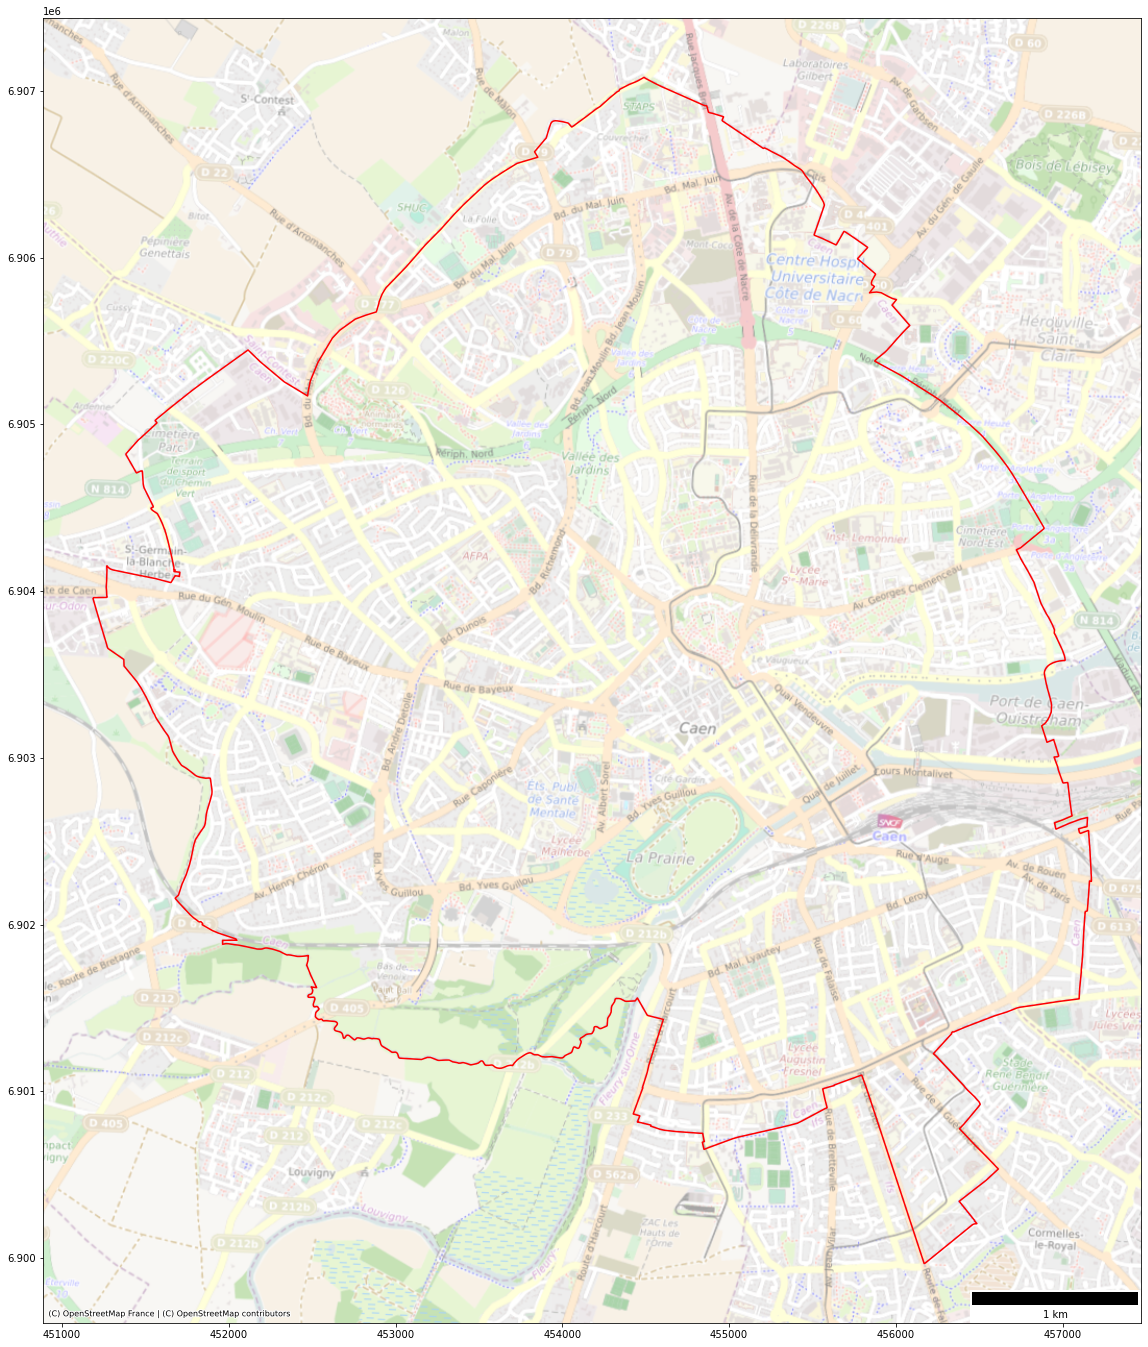

In [17]:
# study area map
# set up plot
f, ax = plt.subplots(1, figsize=(24,24))

# plot study area
ax = sa.to_crs(local_crs).boundary.plot(ax=ax, color = 'red')

# basemap
cx.add_basemap(ax,
               crs=local_crs,
               source = cx.providers.OpenStreetMap.France,
               alpha = 0.5)

# map elements
scalebar = ScaleBar(dx=1,
                    location=(4),
                    height_fraction=0.01
                    )
ax.add_artist(scalebar)

# save map
plt.savefig('./figures/study_area.png', bbox_inches='tight')

## Buffered study area
We will generate a buffered study area to account for accessibility in the border of our main study area. This involves generating a 2 km buffer of our study area, and downloading the street network contained in the new polygon.

In [18]:
sa_buf = copy.deepcopy(sa)

In [20]:
sa_buf['geometry'] = sa.to_crs(local_crs).buffer(2000)
sa_buf = sa_buf.to_crs(4326)

#sa_buf = sa_buf.to_parquet('./data/sa_buf.parquet')

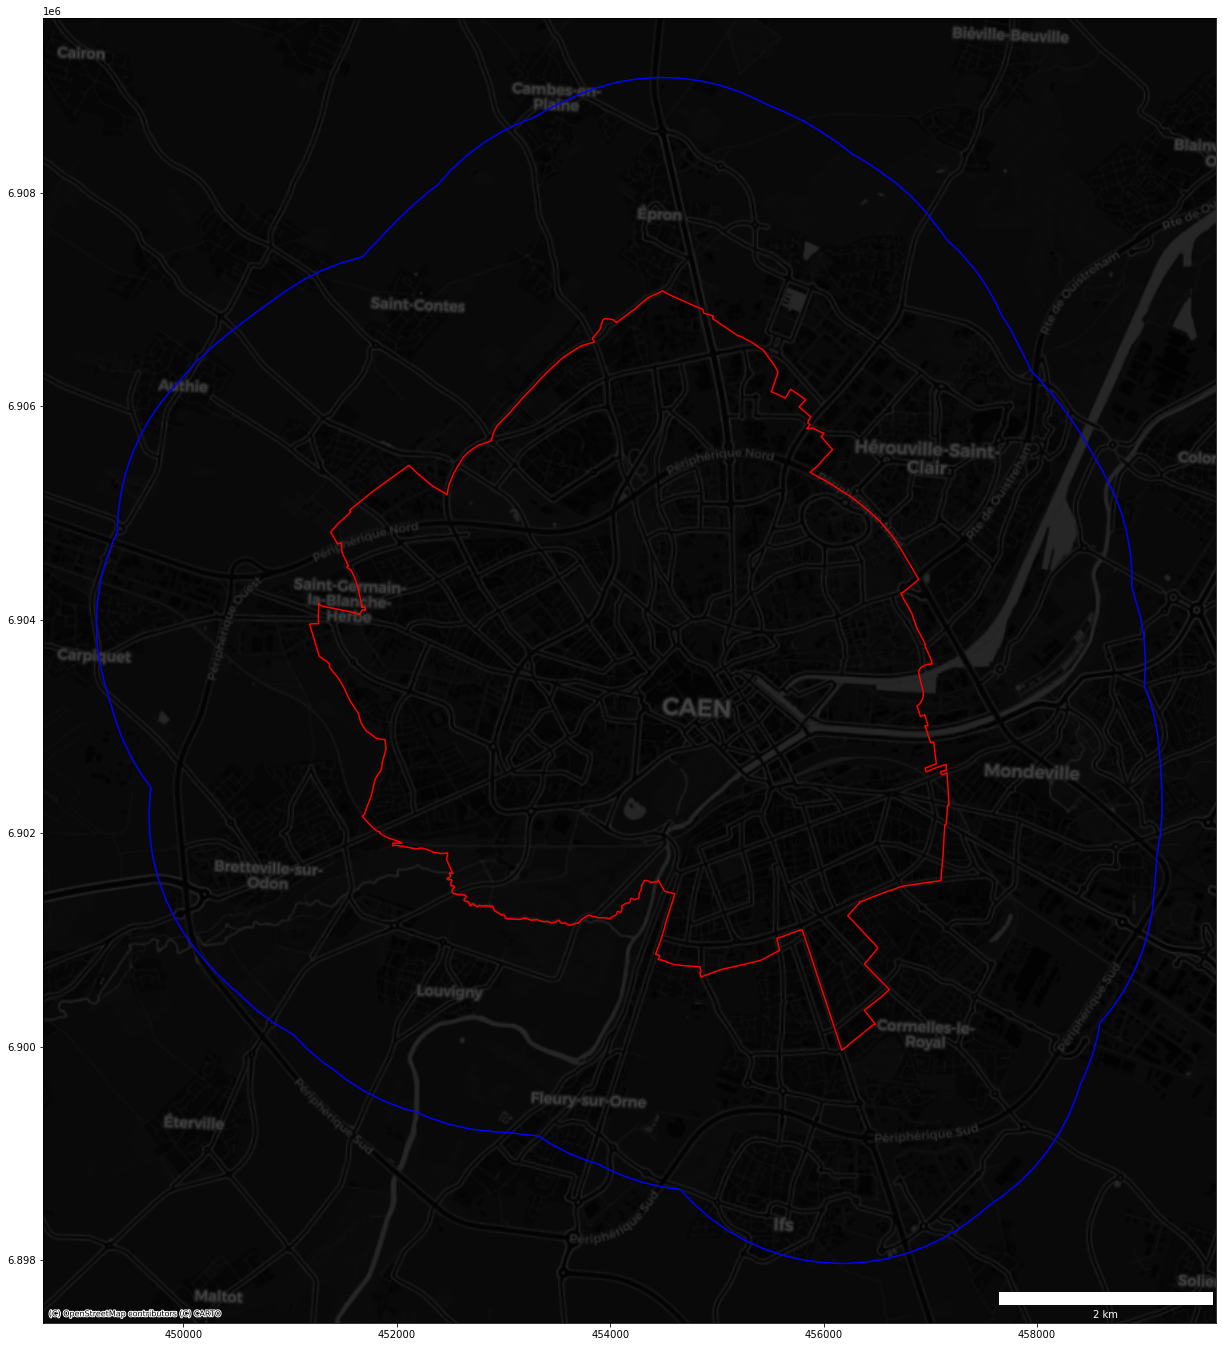

In [25]:
# set up plot
f, ax = plt.subplots(1, figsize=(24,24))

# plot study area
ax = sa.to_crs(local_crs).boundary.plot(ax=ax, color = 'red')

# plot buffered study area
sa_buf.to_crs(local_crs).boundary.plot(ax = ax, color = 'blue')

# basemap
cx.add_basemap(ax,
               crs=local_crs,
               source = cx.providers.CartoDB.DarkMatter,
               alpha = 1)

# map elements
scalebar = ScaleBar(dx=1,
                    location=(4),
                    height_fraction=0.01,
                    color='white',
                    box_alpha=0.0
                    )
ax.add_artist(scalebar)

# save map
plt.savefig('./figures/buffer_study_area.png', bbox_inches='tight')

## Get data
Now that our study area has been defined, we can download our data from OSM. For this exercise we will be using the street network and the buildings in the area.

In [67]:
# streets
G = osmnx.graph_from_polygon(sa_buf.squeeze().geometry, network_type= 'walk')

In [15]:
fp = get_data("Caen")
osm = OSM(fp)
streets_pbf = osm.get_network(network_type="driving")

ValueError: The dataset 'caen' is not available. Available datasets are muenster, prag, greater_london, montevideo, buckinghamshire, berkshire, maldives, tyne_and_wear, midi_pyrenees, cornwall, szczecin, muenster_regbez, germany, romania, nordrhein_westfalen, district_of_columbia, jordan, darmstadt, hertfordshire, moldova, us_northeast, lausanne, stockholm, wales, north_caucasus_fed_district, kaiserslautern, france, phnompenh, zimbabwe, south_fed_district, osnabrueck, perth, south_korea, chile, madagascar, new_hampshire, hamm, tokyo, kentucky, hungary, british_columbia, jamaica, comores, georgia, gliwice, trondheim, montpellier, belgium, utrecht, somerset, martinique, nottinghamshire, limburg, aquitaine, helsinki_region_pbf, hamburg, sucre, prince_edward_island, south_africa_and_lesotho, cheshire, koeln, lincolnshire, norte, gelderland, azores, wien, porto, tonga, buenosaires, colombia, essex, schleswig_holstein, noord_holland, northamptonshire, togo, linz, namibia, zuid_holland, brisbane, angola, wisconsin, ontario, ecuador, far_eastern_fed_district, ukraine, tallinn, africa, berlin, bordeaux, saarbruecken, salzburg, marseille, andorra, niue, north_korea, heilbronn, podkarpackie, bielefeld, bremerhaven, kiew, colorado, oldenburg, portlandme, freiburg, niedersachsen, morocco, ethiopia, montana, gcc_states, staffordshire, cyprus, arkansas, ireland_and_northern_ireland, greenland, bulgaria, nord_est, toulouse, denver, aachen, schwaben, cambridgema, bombay, australia, australia_oceania, aarhus, jerusalem, slovakia, brandenburg, halle, chugoku, luxembourg, brazil, adelaide, slaskie, zambia, micronesia, manchester, languedoc_roussillon, missouri, santacruz, new_brunswick, wyoming, providence, sarajewo, bosnia_herzegovina, corvallis, canary_islands, durham, halifax, alaska, south_sudan, idaho, warwickshire, crimean_fed_district, kiribati, north_dakota, auckland, koblenz, champagne_ardenne, bremen, south_yorkshire, maastricht, malaysia_singapore_brunei, luebeck, devon, podlaskie, peru, usedom, rheinland_pfalz, cook_islands, texas, iceland, oslo, philippines, duesseldorf, warsaw, bonn, potsdam, berkeley, japan, frankfurt, chad, austin, glasgow, nevada, lesotho, uganda, graz, southern_california, wuppertal, oberpfalz, mozambique, bangkok, riga, lubelskie, cambridge, magdeburg, sao_tome_and_principe, niger, hannover, gent, liechtenstein, sheffield, tucson, karlsruhe_regbez, huntsville, goeteborg, south_dakota, liverpool, ile_de_france, kansai, noord_brabant, newyorkcity, flensburg, ulm, colmar, england, friesland, kassel, unterfranken, latvia, east_yorkshire_with_hull, wroclaw, memphis, barcelona, warenmueritz, bahamas, thueringen, bochum, ural_fed_district, oberbayern, kaunas, montreal, sudeste, hawaii, craterlake, cambridgeshire, cape_verde, oxfordshire, nigeria, north_carolina, newdelhi, saskatchewan, scotland, corsica, poitou_charentes, new_zealand, london, tanzania, finland, picardie, santiago, centro, portoalegre, indiana, ottawa, bern, detmold_regbez, drenthe, lebanon, singapore, turin, isole, lodzkie, mecklenburg_vorpommern, centro_oeste, haiti_and_domrep, north_yorkshire, tehran, west_midlands, sweden, lima, strassburg, algeria, dallas, birmingham, genf, malta, hessen, serbia, albania, ivory_coast, konstanz, nordeste, bretagne, macedonia, northwestern_fed_district, volga_fed_district, guinea_bissau, orlando, eindhoven, copenhagen, illinois, leeds, kyrgyzstan, louisiana, paris, nova_scotia, syria, toronto, hokkaido, senegal_and_gambia, fiji, reunion, dorset, sacramento, congo_democratic_republic, gloucestershire, faroe_islands, palau, us_west, helsinki, ulanbator, hampshire, vancouver, canada, zuerich, victoria, washington, provence_alpes_cote_d_azur, manitoba, rhone_alpes, niederbayern, lancashire, freiburg_regbez, rutland, erfurt, saarland, arnhem, nebraska, asia, mittelfranken, portugal, mexico, seoul, china, marshall_islands, bolivia, massachusetts, italy, liberia, lisbon, maine, cuba, sanjose, centre, mazowieckie, croatia, moscow, papua_new_guinea, kenya, bruegge, merseyside, pomorskie, turkey, boulder, thailand, stockton, west_virginia, europe, lithuania, central_fed_district, turkmenistan, malawi, iraq, mainz, guyane, kyushu, usa, djibouti, new_york, netherlands, west_sussex, ohio, santabarbara, paderborn, new_mexico, riodejaneiro, east_sussex, guinea, rostock, south_america, switzerland, montenegro, duesseldorf_regbez, minnesota, kazakhstan, braunschweig, jena, sachsen_anhalt, puerto_rico, equatorial_guinea, denhaag, afghanistan, suriname, schwerin, alexandria, haute_normandie, tennessee, lakegarda, sofia, czech_republic, sachsen, beijing, bogota, zagreb, lapaz, auvergne, madison, north_america, sanfrancisco, ghana, rotterdam, philadelphia, wuerzburg, washingtondc, palma, luxemburg, lubuskie, stuttgart_regbez, norway, us_midwest, quebec, central_america, madrid, mauritania, egypt, canberra, waterloo, mongolia, somalia, vermont, fortcollins, nuernberg, vanuatu, opolskie, mississippi, russia, burkina_faso, belarus, gera, pays_de_la_loire, chubu, uzbekistan, limousin, kanto, laplata, leicestershire, basse_normandie, seattle, michigan, stuttgart, greece, norfolk, greater_manchester, ruegen, alberta, central_african_republic, dublin, basel, warminsko_mazurskie, arizona, augsburg, overijssel, katowice, newfoundland_and_labrador, brandenburghavel, northern_california, karlsruhe, bourgogne, regensburg, bayern, shropshire, lorraine, kaliningrad, denmark, myanmar, leipzig, chemnitz, corse, mauritius, saint_helena_ascension_and_tristan_da_cunha, arnsberg_regbez, herefordshire, ljubljana, gdansk, cairo, bangladesh, cambodia, azerbaijan, eritrea, duisburg, saigon, erlangen, goettingen, isle_of_man, wiltshire, zeeland, mali, hertogenbosch, austria, nunavut, gabon, maryland, iowa, melbourne, wielkopolskie, kujawsko_pomorskie, antarctica, argentina, northumberland, samoa, ostrava, mannheim, frankfurtoder, malopolskie, goerlitz, cusco, us_pacific, bruessel, cork, lodz, kent, guadeloupe, oranienburg, pennsylvania, capetown, curitiba, pakistan, great_britain, venezuela, south_carolina, taiwan, innsbruck, eugene, calgary, malmoe, sul, virginia, israel_and_palestine, sudan, muenchen, alsace, alabama, surrey, brno, suffolk, nicaragua, south_africa, isle_of_wight, yukon, dortmund, indonesia, cottbus, florida, amsterdam, spain, franche_comte, congo_brazzaville, neworleans, cumbria, swaziland, nord_pas_de_calais, dolnoslaskie, iran, guatemala, moenchengladbach, albuquerque, poland, kiel, swietokrzyskie, utah, tajikistan, mayotte, india, bhutan, libya, clermontferrand, nepal, cameroon, edinburgh, sanktpetersburg, estonia, nauru, mexicocity, dessau, northwest_territories, seychelles, new_jersey, nord_ovest, bristol, beirut, bamberg, emden, istanbul, dresden, koeln_regbez, botswana, johannesburg, kansas, antwerpen, tunisia, laos, balaton, derbyshire, vietnam, poznan, worcestershire, sierra_leone, zachodniopomorskie, delaware, groningen, burundi, baghdad, cracow, benin, armenia, slovenia, bedfordshire, belize, oregon, lyon, us_south, new_caledonia, tilburg, miami, tohoku, baku, west_yorkshire, tuvalu, portland, baden_wuerttemberg, budapest, siberian_fed_district, oberfranken, paloalto, shikoku, yemen, solomon_islands, sri_lanka, rwanda, paraguay, kosovo, connecticut, oklahoma, sud, chicago, rhode_island, uruguay, sydney, tuebingen_regbez, flevoland, davis, monaco

<AxesSubplot:>

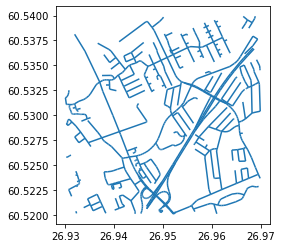

In [13]:
streets_pbf.plot()

In [111]:
# streets
#G = osmnx.graph_from_polygon(sa.squeeze().geometry, network_type= 'walk')

In [69]:
# buildings
buildings = osmnx.geometries_from_polygon(
    sa_buf.squeeze().geometry, tags={"building": True}
)

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [3]:
# amenities
place = 'Caen, France'
amenities = osmnx.geometries_from_place(place, tags={'amenity':True})

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


### Data cleaning
The data we just downloaded is not yet ready for processing. It requires a bit of cleaning.

In [70]:
# clean buildings
buildings = buildings.reset_index()[['geometry']] # keep only geometry and reset index
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)# keep polygons only
buildings['uID'] = range(len(buildings))  # add a unique ID for each building
buildings = buildings[["geometry"]].to_crs(local_crs) # set geometry

In [71]:
buildings.to_parquet('./data/buildings.parquet')

C:\Users\b9066009\AppData\Local\Temp\ipykernel_9364\707751399.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  buildings.to_parquet('./data/buildings.parquet')


In [72]:
# clean streets
G = osmnx.projection.project_graph(G, to_crs=local_crs) # project graph
streets = osmnx.graph_to_gdfs(G, 
                              nodes=False, 
                              edges=True,
                              node_geometry=False,
                              fill_edge_geometry=True)

In [73]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [74]:
streets.to_parquet('./data/streets.parquet')

C:\Users\b9066009\AppData\Local\Temp\ipykernel_9364\1592874957.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  streets.to_parquet('./data/streets.parquet')


In [5]:
# clean amenities
amenities = amenities.to_crs(local_crs).reset_index() # reset index and set crs
amenities['geometry'] = amenities.geometry.centroid # convert to centroids
amenities = amenities[['amenity','geometry']].reset_index() # keep only needed columns

In [60]:
#amenities.to_parquet('./data/amenities.parquet')

C:\Users\b9066009\AppData\Local\Temp\ipykernel_17412\1275985175.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  amenities.to_parquet('./data/amenities.parquet')


### Plot outputs

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\matplotlib_scalebar\scalebar.py:308: DeprecationWarning: The height_fraction argument was deprecated. Use width_fraction instead.
  warnings.warn(


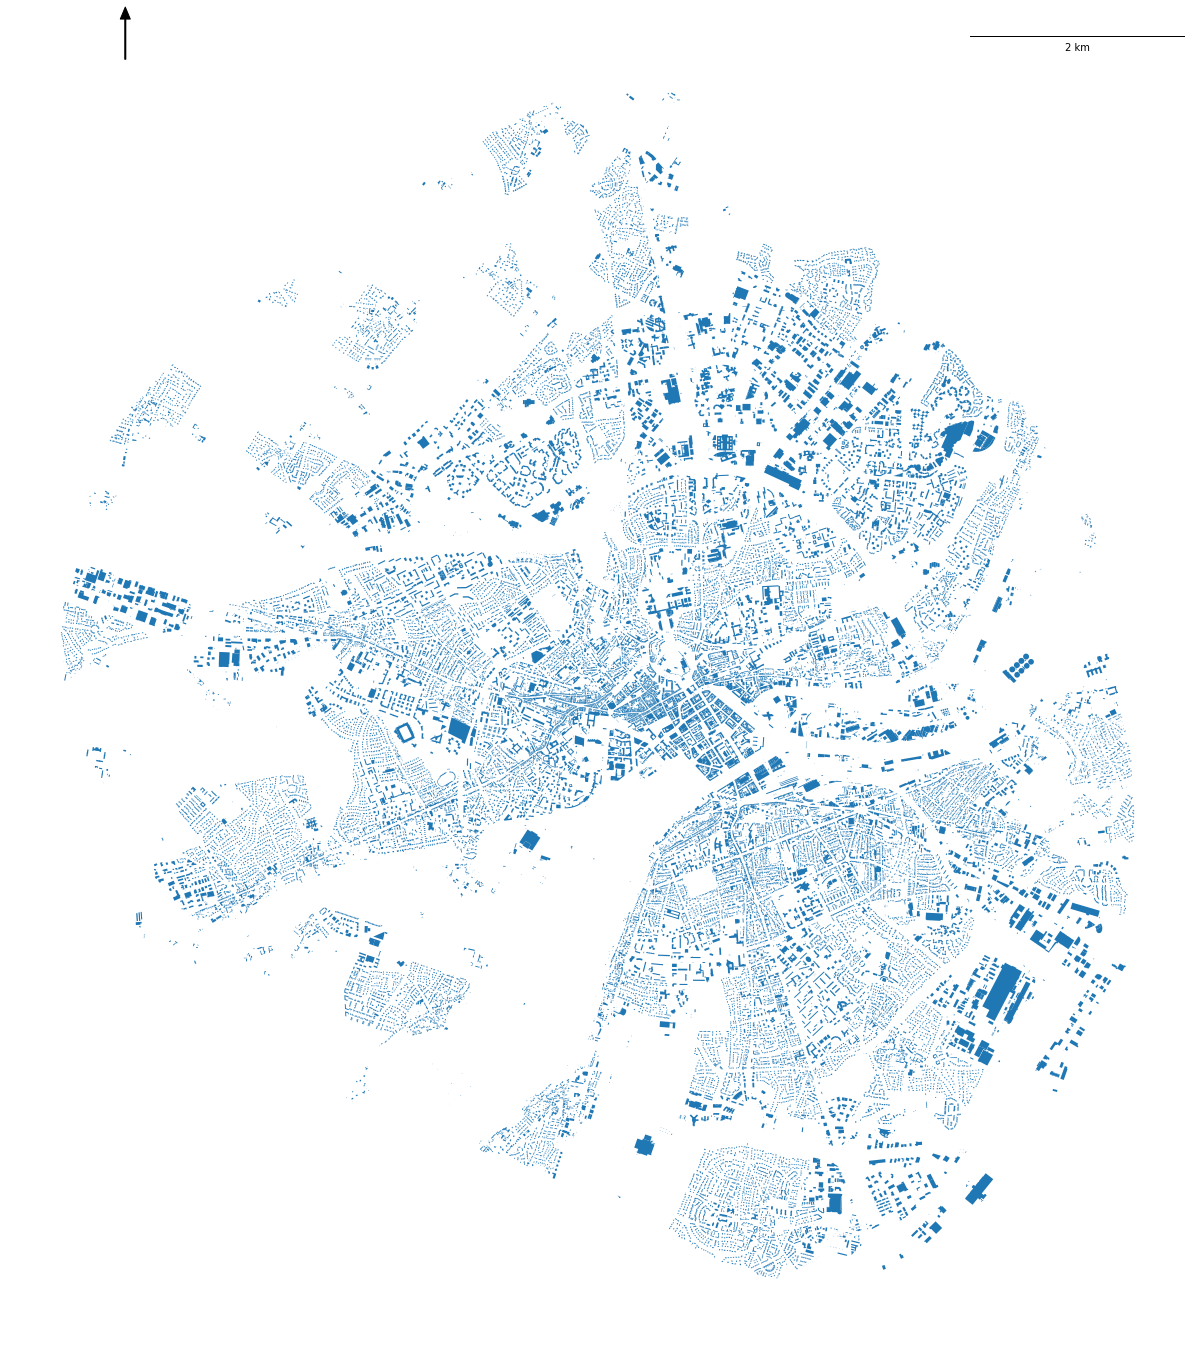

In [78]:
# set up plot
f, ax = plt.subplots(1, figsize=(24,24))

# plot buildings
ax = buildings.plot(ax = ax)

# map elements
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    location=1,
                    height_fraction=0.001
                    )
ax.add_artist(scalebar)

cartoee.add_north_arrow(
    ax, text='', xy=(0.1,1.02), arrow_length=0.04, arrow_color="black", width = 1, headwidth = 10)

plt.savefig('./figures/buildings.png', bbox_inches='tight')

c:\Users\b9066009\Anaconda3\envs\geo_env\lib\site-packages\matplotlib_scalebar\scalebar.py:308: DeprecationWarning: The height_fraction argument was deprecated. Use width_fraction instead.
  warnings.warn(


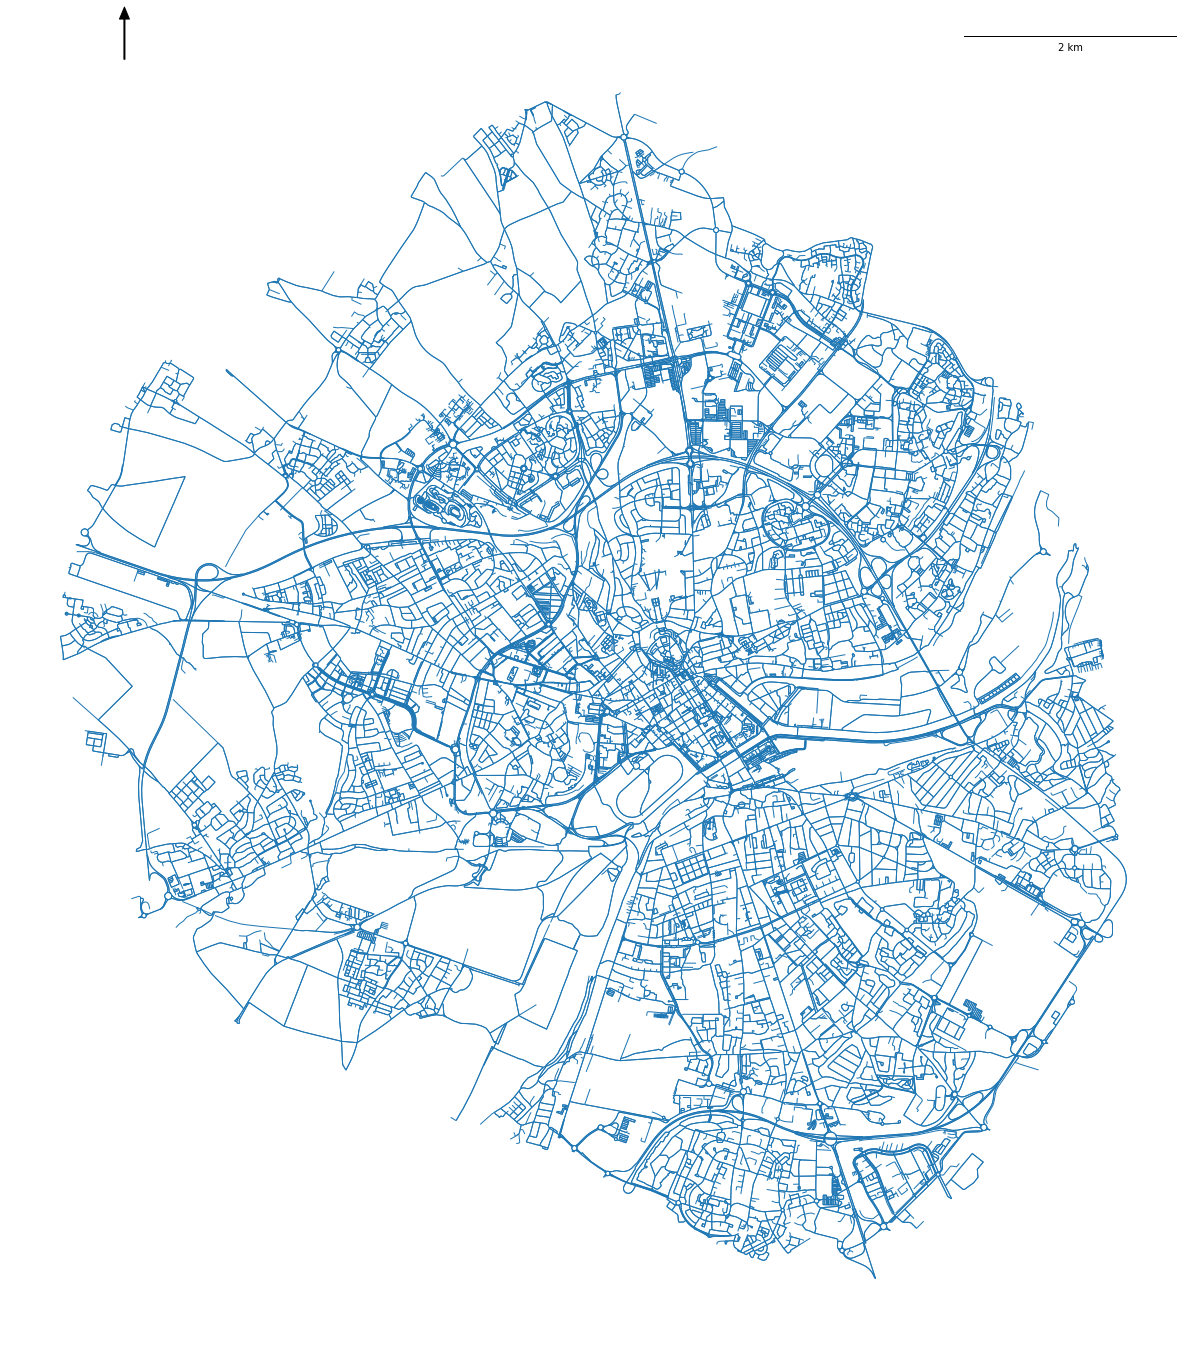

In [81]:
# set up plot
f, ax = plt.subplots(1, figsize=(24,24))

# plot buildings
ax = streets.plot(ax = ax, linewidth=1)

# map elements
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    location=1,
                    height_fraction=0.001
                    )
ax.add_artist(scalebar)

cartoee.add_north_arrow(
    ax, text='', xy=(0.1,1.02), arrow_length=0.04, arrow_color="black", width = 1, headwidth = 10)

plt.savefig('./figures/streets.png', bbox_inches='tight')